In [1]:
# TrainBaseModelAugmentation.ipynb 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt



2025-07-17 02:19:08.975818: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 02:19:08.983412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 02:19:09.000850: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 02:19:09.048710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752736749.114730    2544 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752736749.13

In [2]:
#  Load Dataset
image_size = (180, 180)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "food_6",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
)

Found 500 files belonging to 5 classes.
Using 400 files for training.
Using 100 files for validation.


2025-07-17 02:19:18.287616: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
# Define Data Augmentation 
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
])


2025-07-16 17:09:43.728912: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


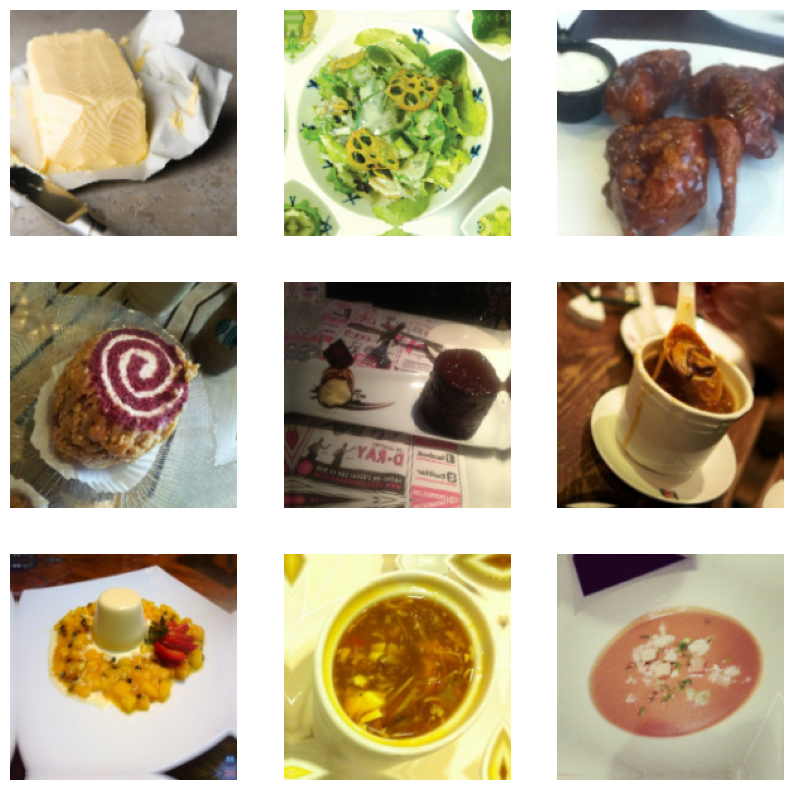

In [7]:
#  Visualize Data Augmentation 
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")
plt.show()


In [4]:

# Setup Transfer Learning Model 
base_model = keras.applications.MobileNetV2(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

inputs = keras.Input(shape=image_size + (3,))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)

/tmp/ipykernel_2544/711168427.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


In [6]:

#  Compiling and Train Model 
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 427ms/step - accuracy: 0.2863 - loss: 1.9379 - val_accuracy: 0.6400 - val_loss: 1.0011
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 292ms/step - accuracy: 0.7051 - loss: 0.8020 - val_accuracy: 0.7700 - val_loss: 0.6493
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.8129 - loss: 0.5867 - val_accuracy: 0.7900 - val_loss: 0.5503
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.8371 - loss: 0.4306 - val_accuracy: 0.8300 - val_loss: 0.5038
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.8792 - loss: 0.3588 - val_accuracy: 0.8600 - val_loss: 0.4701
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step - accuracy: 0.8923 - loss: 0.3288 - val_accuracy: 0.8200 - val_loss: 0.4585
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.8934 - loss: 0.2857 - val_accuracy: 0.8400 - val_loss: 0.4533
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 347ms/step - accuracy: 0.9062 - loss: 0.2651 - val_accuracy: 0

In [7]:
model.save("mobilenet_augmented.keras")



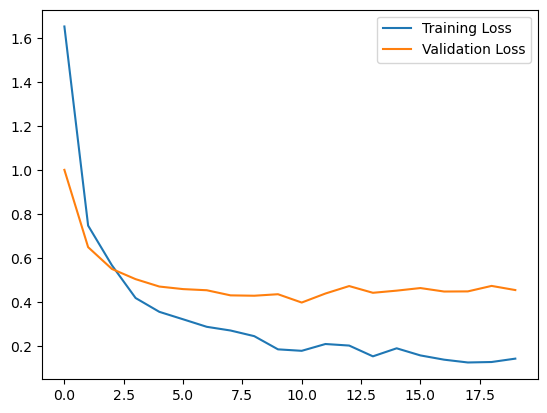

In [8]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

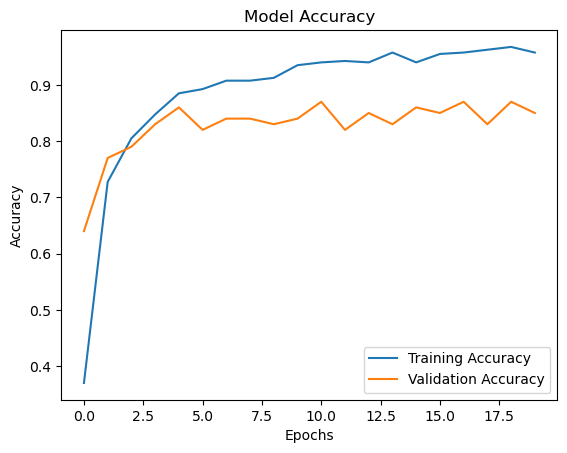

In [9]:
plt.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label="Training Accuracy")
plt.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
